# Setup

In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd

import seaborn as sns

# sns.set(style='whitegrid')

In [2]:
class KArmedBandit:
    def __init__(self, k=10):
        
        self.k = k
        self.action_values = np.random.standard_normal(size=self.k)

    def graph(self):        
        
        rewards = [np.random.normal(av, 1, size=5000) for av in self.action_values]  # used for graphing only
        
        temp_df = pd.DataFrame({'q*': self.action_values, 'reward_dist': rewards})
        temp_df = pd.DataFrame({
                  col:np.repeat(temp_df[col].values, temp_df['reward_dist'].str.len())
                  for col in temp_df.columns.drop('reward_dist')}).assign(**{'reward_dist':np.concatenate(temp_df['reward_dist'].values)})[temp_df.columns]
        
        ax = sns.violinplot(x='q*', y='reward_dist', data=temp_df, order=self.action_values)
        ax.set(xlabel='Action', ylabel='Reward Distribution')
        ax.set_xticklabels(np.arange(0, self.k))
        
    def give_reward(self, action):
        return np.random.normal(self.action_values[action], 1)
        

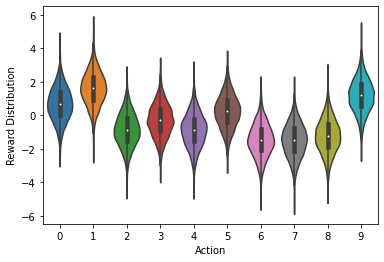

In [7]:
K = 10
bandit = KArmedBandit(K)
bandit.graph()  # The agent does not have this knowledge

Next, several methods for discovering the optimal action will be implemented.

# Helper Functions

In [4]:
# Similar to np.argmax, but provides all indices instead of only the first.
# https://stackoverflow.com/questions/17568612/how-to-make-numpy-argmax-return-all-occurrences-of-the-maximum

def allmax(a):
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_

# Greedy Policy

The agent will always choose the best action (indicated by the largest q-value in q_values). If multiple actions give the same reward, an action will be chosen randomly and uniformly.

See section 2.4 of Sutton & Barto for incremental update derivation.

In [8]:
STEPS = 500_000
q_values = np.zeros(K)
action_count = np.zeros(K)  # number of times an action has been selected, required to update q-value

for step in range(0, STEPS):
    
    greedy_action = np.random.choice(allmax(q_values))
    
    action_count[greedy_action] += 1
    
    # Update q_values at the appropriate index
    reward = bandit.give_reward(greedy_action)
    q_values[greedy_action] = q_values[greedy_action] + (1/action_count[greedy_action]) * (reward - q_values[greedy_action])


for action,q_val in enumerate(q_values):
    print('ACTION:', action, '\t', 'Q-VALUE:', q_val)
print('BEST ACTION:', np.argmax(q_values))

ACTION: 0 	 Q-VALUE: -1.5562077874804783
ACTION: 1 	 Q-VALUE: 0.0
ACTION: 2 	 Q-VALUE: -2.369296806352642
ACTION: 3 	 Q-VALUE: -0.326743129387824
ACTION: 4 	 Q-VALUE: -0.6529859130573048
ACTION: 5 	 Q-VALUE: 0.22525625795962304
ACTION: 6 	 Q-VALUE: -0.38880520828701526
ACTION: 7 	 Q-VALUE: -2.3082791232925626
ACTION: 8 	 Q-VALUE: -2.400207071486763
ACTION: 9 	 Q-VALUE: 0.0
BEST ACTION: 5


Clearly, some actions are never even tried. In this example, once a single Q-value becomes greater than 0, it is chosen 100% of the time. This lack of exploration can mean that the optimal action is never discovered by the agent. One common solution to this is to introduce epsilon, a small probability of randomly choosing uniformly between all actions, regardless of action-value.

# Epsilon-Greedy Policy

Frequently, the agent chooses the best action, similar to the greedy policy above. However, for a small probability epsilon, the agent randomly selects among all actions uniformly.